In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt

# Import and Process Data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = np.where(data['quality']<6,0,1)


In [3]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Create model

In [4]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [26]:
## Fucntion to create the model
def createANNmodel(algo):
  assert algo in ['xavier','kaiming'], 'Invalid weight initialization algo'
  net = ANNwine()

  # change the weights using Xavier/ Kaiming distribution
  [nn.init.xavier_normal_(p[1].data) if algo == 'xavier' else nn.init.kaiming_normal_(p[1].data,nonlinearity='relu') for p in net.named_parameters() if 'weight' in p[0]]

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer function
  optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

  return net,lossfun,optimizer

# Train the model

In [27]:
def trainTheModel(algo,numepochs):

  winenet, lossfun, optimizer = createANNmodel(algo)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

# Run the model



In [31]:
def RunTheModel():
  algos = ['kaiming','xavier']
  numepochs = 50
  train_accuracy = np.zeros((len(algos),numepochs))
  test_accuracy  = np.zeros((len(algos),numepochs))
  losses         = np.zeros((len(algos),numepochs))

  # Loop over the algorithms for weight initializations
  for i,algo in enumerate(algos):
    trainAcc, testAcc, epoch_losses = trainTheModel(algo,numepochs)
    train_accuracy[i,:] = trainAcc
    test_accuracy[i,:]  = testAcc
    losses[i,:]         = epoch_losses.data.numpy()

  return train_accuracy, test_accuracy, losses, algos, numepochs

In [32]:
train_accuracy, test_accuracy, losses, algos, numepochs = RunTheModel()

# Visualize the output

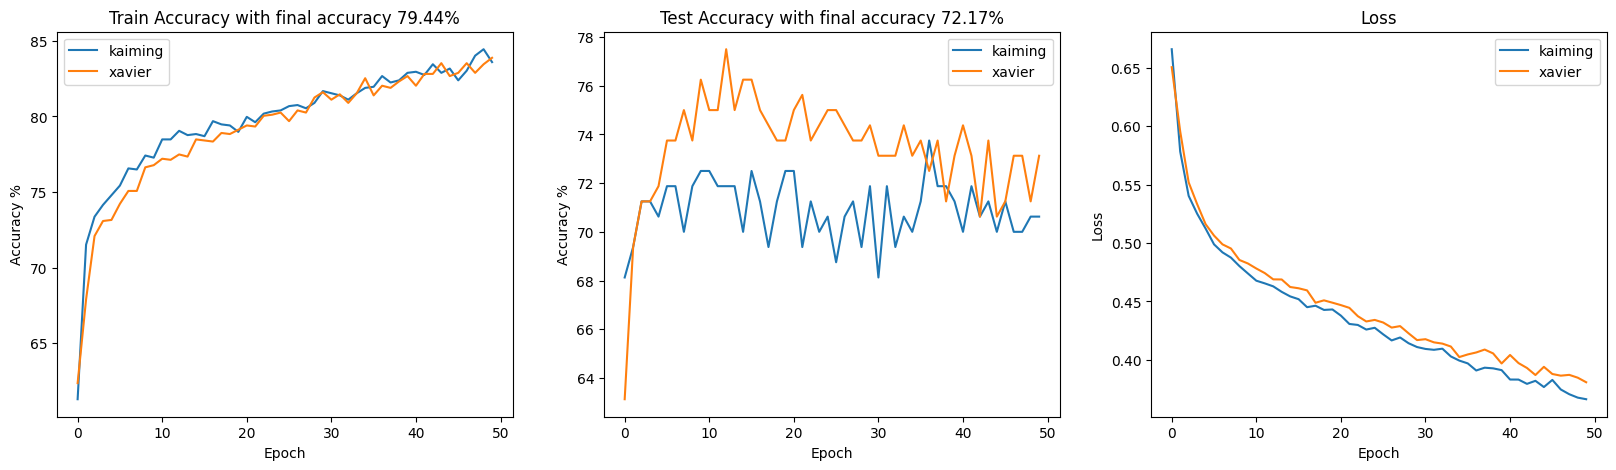

In [33]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

for i in range(len(algos)):
  ax[0].plot(range(numepochs),train_accuracy[i,:],label=algos[i])
  ax[1].plot(range(numepochs),test_accuracy[i,:],label=algos[i])
  ax[2].plot(range(numepochs),losses[i,:],label=algos[i])

ax[0].set_title(f'Train Accuracy with final accuracy {np.mean(train_accuracy[-5:]):0.2f}%')
ax[1].set_title(f'Test Accuracy with final accuracy {np.mean(test_accuracy[-5:]):0.2f}%')
ax[2].set_title('Loss')

for i, axs in enumerate(ax):
  axs.set_xlabel('Epoch')
  axs.legend()

[ax[i].set_ylabel('Accuracy %') for i in range(len(ax))]

ax[2].set_ylabel('Loss')

plt.show();

In [34]:
# Run the model 10 times for each algo
import time

numExps = 50

results = np.zeros(((numExps,3,len(algos))))

startTime = time.process_time()

for expi in range(numExps):
  train_accuracy, test_accuracy, losses, algos, _ = RunTheModel()
  results[expi,0,:] = np.mean(train_accuracy[-5:],axis=1)
  results[expi,1,:] = np.mean(test_accuracy[-5:],axis=1)
  results[expi,2,:] = np.mean(losses[-5:],axis=1)

  timeElapsed = time.process_time() - startTime
  print(f'Experiment {expi+1}/{numExps} completed in {timeElapsed:3.0f} seconds')


Experiment 1/50 completed in   9 seconds
Experiment 2/50 completed in  18 seconds
Experiment 3/50 completed in  27 seconds
Experiment 4/50 completed in  35 seconds
Experiment 5/50 completed in  44 seconds
Experiment 6/50 completed in  53 seconds
Experiment 7/50 completed in  62 seconds
Experiment 8/50 completed in  71 seconds
Experiment 9/50 completed in  80 seconds
Experiment 10/50 completed in  89 seconds
Experiment 11/50 completed in  97 seconds
Experiment 12/50 completed in 106 seconds
Experiment 13/50 completed in 116 seconds
Experiment 14/50 completed in 125 seconds
Experiment 15/50 completed in 133 seconds
Experiment 16/50 completed in 143 seconds
Experiment 17/50 completed in 152 seconds
Experiment 18/50 completed in 160 seconds
Experiment 19/50 completed in 169 seconds
Experiment 20/50 completed in 179 seconds
Experiment 21/50 completed in 187 seconds
Experiment 22/50 completed in 196 seconds
Experiment 23/50 completed in 205 seconds
Experiment 24/50 completed in 214 seconds
E

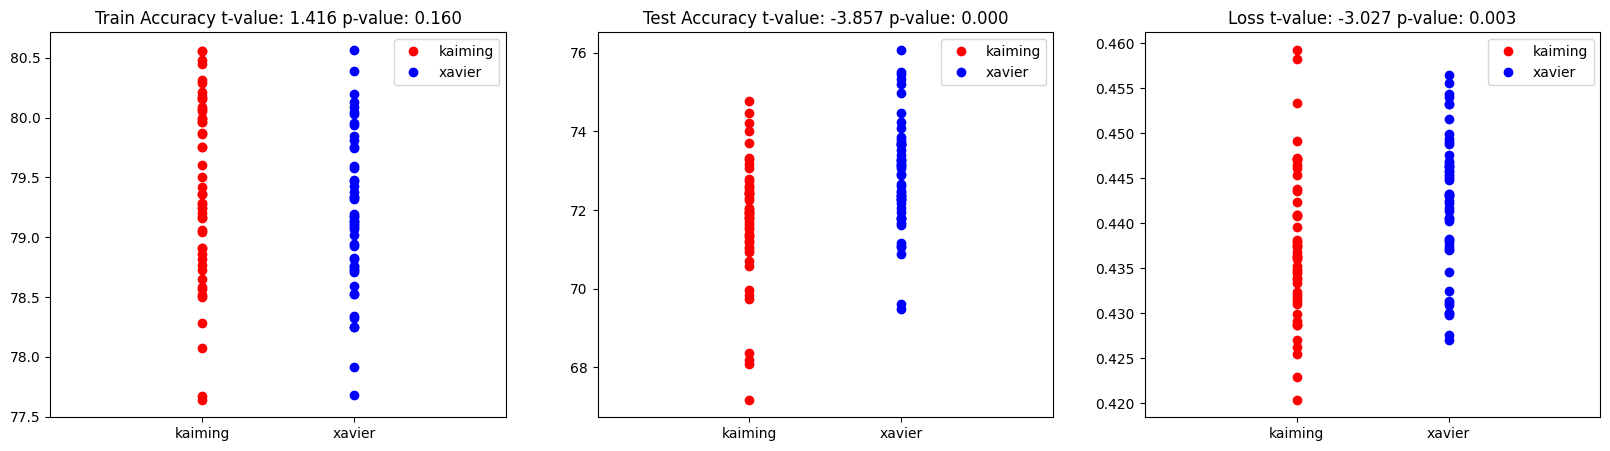

In [35]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
metric = ['Train Accuracy','Test Accuracy', 'Loss'] # Corrected order to match results array

for i in range(len(metric)):

  # Plot the results for each algorithm
  ax[i].plot(np.zeros(numExps),results[:,i,0],'ro',label=algos[0])
  ax[i].plot(np.zeros(numExps)+1,results[:,i,1],'bo',label=algos[1])


  t,p = stats.ttest_ind(results[:,i,0],results[:,i,1])
  ax[i].set_title(f'{metric[i]} t-value: {t:0.3f} p-value: {p:0.3f}')

  ax[i].set_xlim(([-1,2]))
  ax[i].set_xticks([0, 1])
  ax[i].set_xticklabels(algos)
  ax[i].legend()


plt.show();